Welcome! In this post, I will show you how to conduct a simulation of two-dimensional heat diffusion in various ways: matrix multiplication, sparse matrix in `JAX`, direct operation with `numpy`, and with `JAX`.

## The Math and Science Behind Two-dimensional Heat Diffusion

By definition, heat diffusion is the "process of determining the spatial distribution of temperature on a conductive surface over time by using the heat equation." You can read more about heat diffusions [here](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.sciencedirect.com/topics/computer-science/heat-diffusion%23:~:text%3DHeat%2520diffusion%2520is%2520defined%2520as,based%2520on%2520its%2520initial%2520distribution.&ved=2ahUKEwjJgqjJ6NOJAxVr5MkDHZt1JToQFnoECEQQAw&usg=AOvVaw2FzqzbG0Jv7qLpb3Yp3v9f).

This is the equation for two-dimensional heat-diffusions:

$$
\frac{\partial f(x, t)}{\partial t} = \frac{\partial^2f}{\partial x^2} + \frac{\partial^2f}{\partial y^2}.
$$

For the purpose of demonstration in this post, we will use the following values for N and &#949; (epsilon).

In [1]:
#| code-copy: true
N = 101
epsilon = 0.2

This will be the initial condition for our heat diffusion: putting 1 unit of heat at the midpoint.

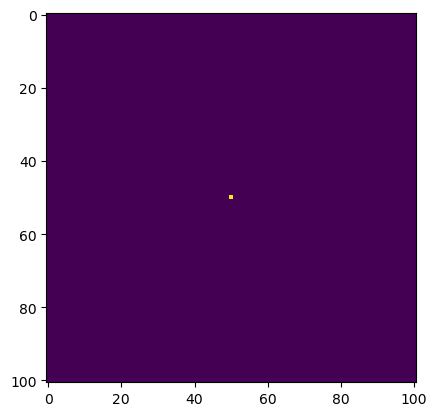

In [2]:
#| code-copy: true
import numpy as np
from matplotlib import pyplot as plt
# construct initial condition: 1 unit of heat at midpoint. 
u0 = np.zeros((N, N))
u0[int(N/2), int(N/2)] = 1.0
plt.imshow(u0)

## Using Matrix Multiplication

Let's use matrix-vector multiplication to simulate the heat diffusion in the 2D space. The vector here is created by `flatten`ing the current solution $u_{i, j}^k$. Each iteration of the update is given by:

In [3]:
#| code-copy: true
def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep, via matrix-vector multiplication
    Args:
        A: The 2d finite difference matrix, N^2 x N^2. 
        u: N x N grid state at timestep k.
        epsilon: stability constant.

    Returns:
        N x N Grid state at timestep k+1.
    """
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u

In other words, we view $u_{i, j}^k$ as the element with index $N \times i + j$ in a vector of length $N^2$. We'll put the function above in `heat_equation.py`.

Following the indexing used in `advance_time_matvecmul(A, u, epsilon)`, the matrix `A` has size $N^2 \times N^2$, without all-zero rows or all-zero columns. The corresponding `A` matrix is given by:

In [4]:
#| code-copy: true
n = N * N
diagonals = [-4 * np.ones(n), 
             np.ones(n-1), 
             np.ones(n-1), 
             np.ones(n-N), 
             np.ones(n-N)]

diagonals[1][(N-1)::N] = 0
diagonals[2][(N-1)::N] = 0
A = (np.diag(diagonals[0]) + np.diag(diagonals[1], 1) 
     + np.diag(diagonals[2], -1) + np.diag(diagonals[3], N) 
     + np.diag(diagonals[4], -N))

We will define a function `get_A(N)` that takes in the value `N` as the argument and returns the corresponding matrix `A` in `heat_equation.py`. This is what the equation looks like:

In [5]:
import inspect
from heat_equation import get_A

print(inspect.getsource(get_A))

def get_A(N):
    """ Returns the corresponding matrix A according to N

    Returns:
        N^2 x N^2 matrix without all-zero rows or all-zero columns
    """

    n = N * N
    diagonals = [-4 * np.ones(n), 
                 np.ones(n-1), 
                 np.ones(n-1), 
                 np.ones(n-N), 
                 np.ones(n-N)]
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0
    A = np.diag(diagonals[0]) + np.diag(diagonals[1], 1) + np.diag(diagonals[2], -1) + np.diag(diagonals[3], N) + np.diag(diagonals[4], -N)

    return A



Let's run the simiulation with `get_A()` and `advance_time_matvecmul()` fro 2700 iterations and see how long it takes! 

In [6]:
advance_time_matvecmul(A, u0, epsilon)
get_A(N)

array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]])

Let's run the code above for 2700 iterations and see how long it takes!

Simulation time (without visualization): 85.92 seconds


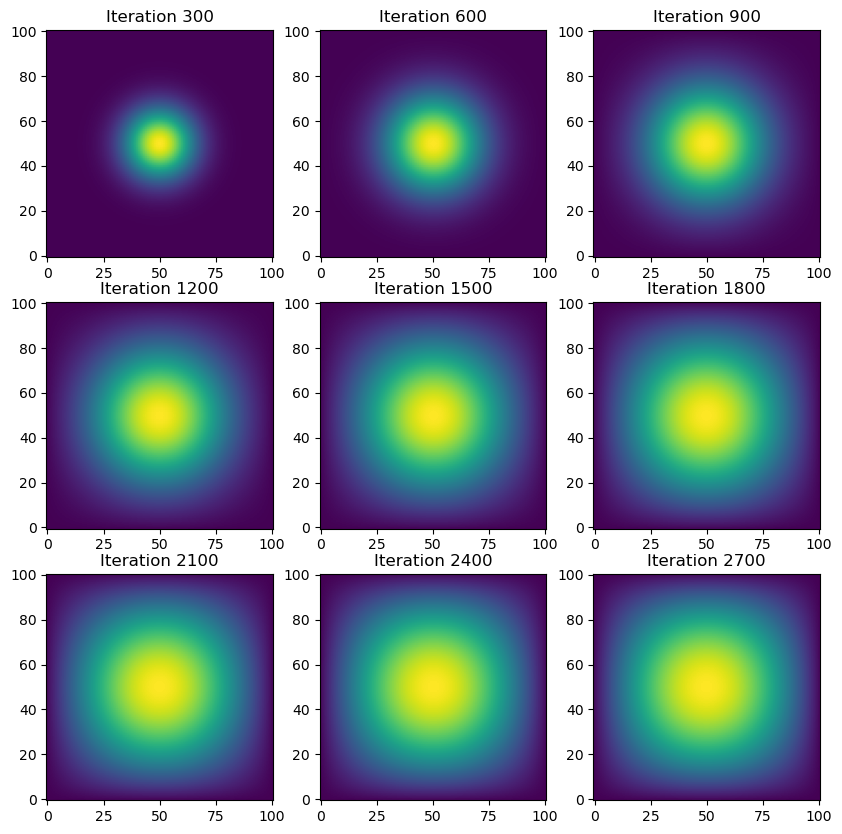

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import time

# Parameters
num_iterations = 2700
interval = 300  # Interval for saving snapshots for visualization

# Initial condition: 1 unit of heat at midpoint
u = np.zeros((N, N))
u[int(N / 2), int(N / 2)] = 1.0

# Get the matrix A for finite difference
A = get_A(N)

# Array to store intermediate solutions for visualization
snapshots = []

# Run the simulation
start_time = time.time()
for i in range(num_iterations):
    u = advance_time_matvecmul(A, u, epsilon)
    if (i + 1) % interval == 0:
        snapshots.append(u.copy())

# Measure the simulation time
simulation_time = time.time() - start_time
print(f"Simulation time (without visualization): {simulation_time:.2f} seconds")

# Visualization: 3x3 grid of heatmaps for snapshots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(snapshots):
        im = ax.imshow(snapshots[idx], cmap='viridis', origin='lower')
        ax.set_title(f"Iteration {interval * (idx + 1)}")
    ax.axis('on')

Looks like that took over a minute to run! 

## Sparse Matrix in `jax`

Let's try running the same simulation using sparse matrix in JAX. To do that, we'll define a function `get_sparse_A(N)` that returns `A_sp_matrix`, which is the same as the matrix `A` but in a sparse format. This is what `get_sparse_A(N)` looks like:

In [8]:
from heat_equation import get_sparse_A

print(inspect.getsource(get_sparse_A))

def get_sparse_A(N):
    """Constructs the finite difference matrix for 2D heat diffusion in sparse format."""
    return sparse.BCOO.fromdense(jnp.array(get_A(N)))



Simulation time (without visualization): 7.82 seconds


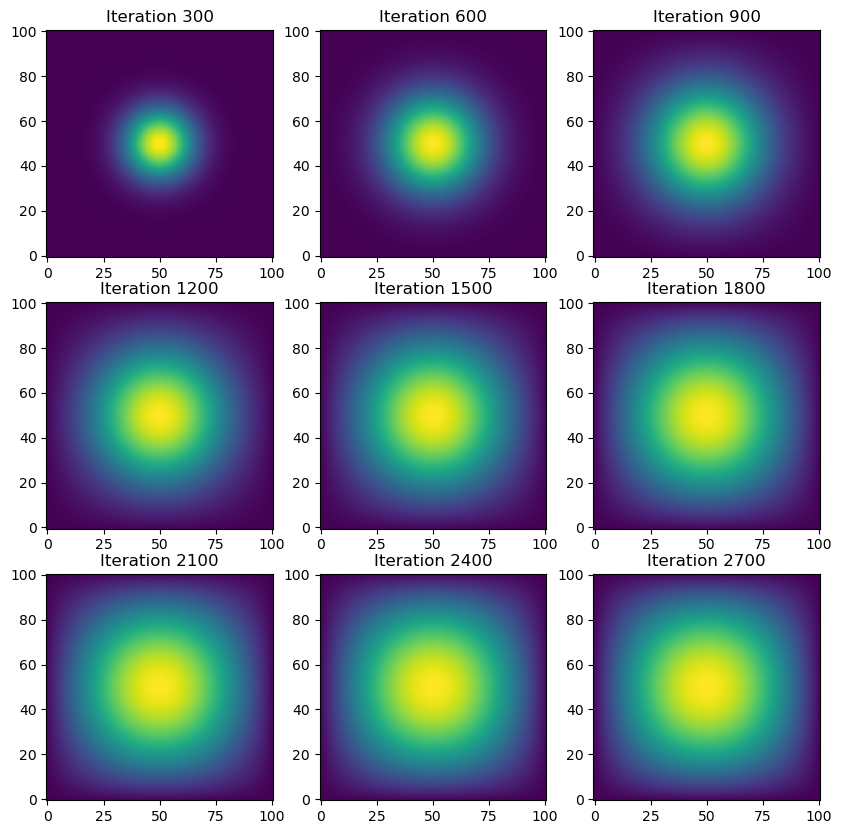

In [9]:
from heat_equation import get_sparse_A
import jax.numpy as jnp
from jax.experimental import sparse
import timeit

# Parameters
num_iterations = 2700
interval = 300  # Interval for saving snapshots for visualization

# Initial condition: 1 unit of heat at midpoint
u = np.zeros((N, N))
u[int(N / 2), int(N / 2)] = 1.0

# Get the matrix A for finite difference
A = get_sparse_A(N)

# Array to store intermediate solutions for visualization
snapshots = []

# Run the simulation
start_time = time.time()
for i in range(num_iterations):
    u = advance_time_matvecmul(A, u, epsilon)
    if (i + 1) % interval == 0:
        snapshots.append(u.copy())

# Measure the simulation time
simulation_time = time.time() - start_time
print(f"Simulation time (without visualization): {simulation_time:.2f} seconds")

# Visualization: 3x3 grid of heatmaps for snapshots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(snapshots):
        im = ax.imshow(snapshots[idx], cmap='viridis', origin='lower')
        ax.set_title(f"Iteration {interval * (idx + 1)}")
    ax.axis('on')

It only took 13 seconds to run when using sparse matrix in JAX! That's an impressive improvement! But can we do better?

## Direction Operation with `numpy`

Let's simplify the matrix multiplications done in `advance_time_matvecmul(A, u, epsilon)` by using `np.roll()` in `Numpy`. To do this, we'll write a function `advance_time_numpy(u, epsilon)` that advances the solution by one timestep in the file `heat_equation.py`. This is what `advance_time_numpy(u, epsilon)` looks like:

In [10]:
import inspect
from heat_equation import advance_time_numpy

print(inspect.getsource(advance_time_numpy))

def advance_time_numpy(u, epsilon):
    """Advances the heat diffusion solution by one timestep using numpy operations."""
    
    # Create a padded version of u with zeros around the border
    u_pad = np.pad(u, pad_width=1, mode='constant', constant_values=0)

    # Calculate the updated values by rolling the array
    u_new = (1 - 4 * epsilon) * u_pad[1:-1, 1:-1] + \
            epsilon * (np.roll(u_pad, shift=1, axis=0)[1:-1, 1:-1] + 
                       np.roll(u_pad, shift=-1, axis=0)[1:-1, 1:-1] +
                       np.roll(u_pad, shift=1, axis=1)[1:-1, 1:-1] + 
                       np.roll(u_pad, shift=-1, axis=1)[1:-1, 1:-1]) 
    return u_new



Simulation time (without visualization): 0.47 seconds


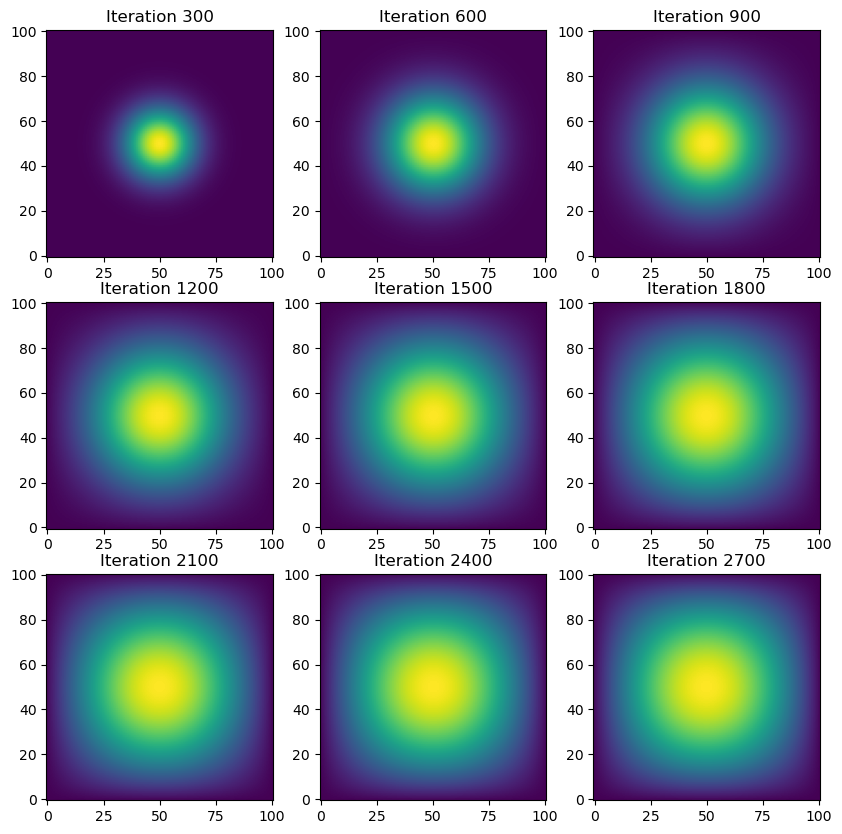

In [11]:
from heat_equation import get_sparse_A
import jax.numpy as jnp
from jax.experimental import sparse
import timeit

# Parameters
num_iterations = 2700
interval = 300  # Interval for saving snapshots for visualization

# Initial condition: 1 unit of heat at midpoint
u = np.zeros((N, N))
u[int(N / 2), int(N / 2)] = 1.0

# Get the matrix A for finite difference
A = get_sparse_A(N)

# Array to store intermediate solutions for visualization
snapshots = []

# Run the simulation
start_time = time.time()
for i in range(num_iterations):
    u = advance_time_numpy(u, epsilon)
    if (i + 1) % interval == 0:
        snapshots.append(u.copy())

# Measure the simulation time
simulation_time = time.time() - start_time
print(f"Simulation time (without visualization): {simulation_time:.2f} seconds")

# Visualization: 3x3 grid of heatmaps for snapshots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(snapshots):
        im = ax.imshow(snapshots[idx], cmap='viridis', origin='lower')
        ax.set_title(f"Iteration {interval * (idx + 1)}")
    ax.axis('on')

Amazing! That only took half a second to run. Let's see if we can do even better with JAX!

## With `jax`

Let's use `jax` to define a function `advance_time_jax(u, epsilon)` that does similar just-in-time compilation done in `advance_time_numpy(u, epsilon)`. Here's what `advance_time_jax(u, epsilon)` looks like:

In [12]:
import inspect
from heat_equation import advance_time_jax

print(inspect.getsource(advance_time_jax))

@jax.jit
def advance_time_jax(u, epsilon):
    """Advances the heat diffusion solution by one timestep using JAX operations."""
    u_pad = jnp.pad(u, pad_width=1, mode='constant', constant_values=0)
    
    u_new = (1 - 4 * epsilon) * u_pad[1:-1, 1:-1] + \
            epsilon * (jnp.roll(u_pad, shift=1, axis=0)[1:-1, 1:-1] + 
                       jnp.roll(u_pad, shift=-1, axis=0)[1:-1, 1:-1] +
                       jnp.roll(u_pad, shift=1, axis=1)[1:-1, 1:-1] +
                       jnp.roll(u_pad, shift=-1, axis=1)[1:-1, 1:-1]) 
    return u_new



Simulation time (without visualization): 0.20 seconds


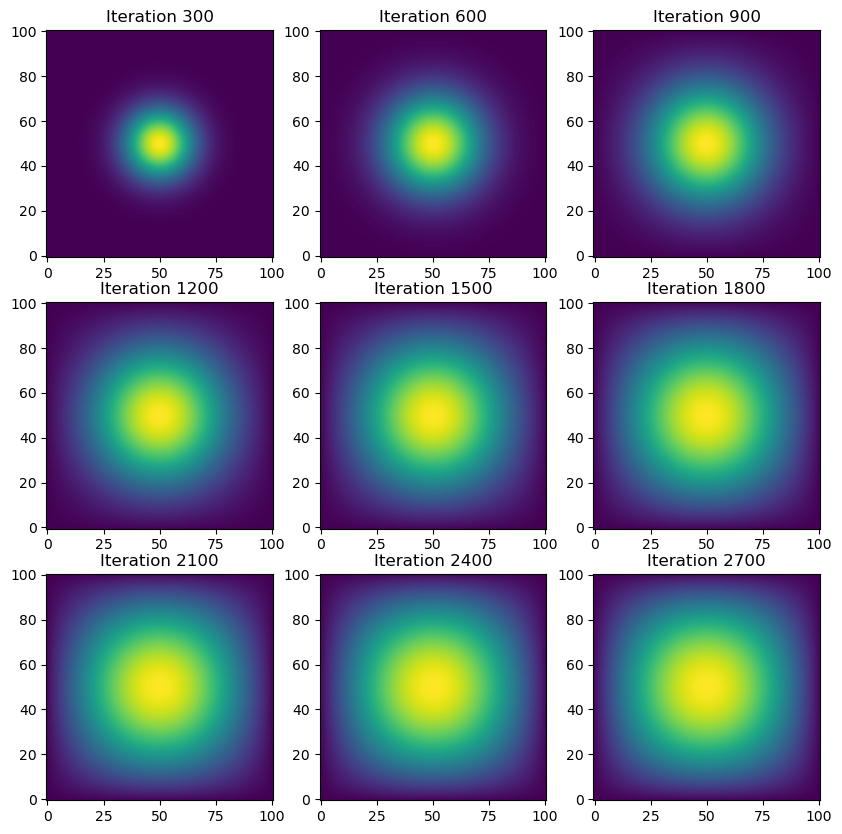

In [13]:
from heat_equation import get_sparse_A
import jax.numpy as jnp
from jax.experimental import sparse
import timeit

# Parameters
num_iterations = 2700
interval = 300  # Interval for saving snapshots for visualization

# Initial condition: 1 unit of heat at midpoint
u = np.zeros((N, N))
u[int(N / 2), int(N / 2)] = 1.0

# Get the matrix A for finite difference
A = get_sparse_A(N)

# Array to store intermediate solutions for visualization
snapshots = []

# Run the simulation
start_time = time.time()
for i in range(num_iterations):
    u = advance_time_jax(u, epsilon)
    if (i + 1) % interval == 0:
        snapshots.append(u.copy())

# Measure the simulation time
simulation_time = time.time() - start_time
print(f"Simulation time (without visualization): {simulation_time:.2f} seconds")

# Visualization: 3x3 grid of heatmaps for snapshots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    if idx < len(snapshots):
        im = ax.imshow(snapshots[idx], cmap='viridis', origin='lower')
        ax.set_title(f"Iteration {interval * (idx + 1)}")
    ax.axis('on')

Less than half a second! That's even better than using direction operation with `Numpy`!

## Comparison

In conclusion, it’s much faster to use JAX to perform the heat diffusion simulation than using traditional NumPy operations or matrix-vector multiplication. By leveraging JAX’s just-in-time (JIT) compilation and automatic differentiation capabilities, we can optimize the performance significantly, especially for large-scale computations that require iterative updates.

## 